In [1]:
import cv2
import mediapipe as mp
import numpy as np
import csv
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
landmarks = ['class']
for val in range(1, 33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [6]:
# Load the .pkl file for the first set of data
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [7]:
# Load the .pkl file for the second set of data
with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [8]:
#r"C:\Users\eddcr\Downloads\Wrong Squat\cave in backlight\squat (2).mp4"
#r"C:\Users\eddcr\Downloads\FYP Dataset\squat (39).mp4"
#r"C:\Users\eddcr\Downloads\Fit3D Dataset\squat\squat (2).mp4"
#video_path = r"C:\Users\eddcr\Downloads\FYP Dataset\squat (39).mp4"
#r"C:\Users\eddcr\Downloads\Test\idk.mp4"

counter = 0
current_stage = ''
cap = cv2.VideoCapture(0)
pause = False  # Flag to indicate whether the video is paused
up_accuracy = []
down_accuracy = []   
upbad_accuracy = []
downbad_accuracy = [] 
bend_accuracy = []   
cavein_accuracy = []  
caveout_accuracy = [] 
good_accuracy = []  
    
# initiate holistic model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detection
        results = pose.process(image)

        # Recolor image to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        try:
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns=landmarks[1:])
            body_language_class1 = model1.predict(X)[0]
            body_language_prob1 = model1.predict_proba(X)[0]
            print(body_language_class1, body_language_prob1)
            
            body_language_class2 = model2.predict(X)[0]
            body_language_prob2 = model2.predict_proba(X)[0]
            print(body_language_class2, body_language_prob2)
            
            # Append confidence values to the lists based on the detected class
            if body_language_class1 == 'up':
                up_accuracy.append(body_language_prob1[np.argmax(body_language_prob1)])
            elif body_language_class1 == 'down':
                down_accuracy.append(body_language_prob1[np.argmax(body_language_prob1)])
            elif body_language_class1 == 'upbad':
                upbad_accuracy.append(body_language_prob1[np.argmax(body_language_prob1)])
            elif body_language_class1 == 'downbad':
                downbad_accuracy.append(body_language_prob1[np.argmax(body_language_prob1)])
            
            
            
            if body_language_class2 == 'bend':
                bend_accuracy.append(body_language_prob2[np.argmax(body_language_prob2)])
            elif body_language_class2 == 'cavein':
                cavein_accuracy.append(body_language_prob2[np.argmax(body_language_prob2)])
            elif body_language_class2 == 'caveout':
                caveout_accuracy.append(body_language_prob2[np.argmax(body_language_prob2)])
            elif body_language_class2 == 'good':
                good_accuracy.append(body_language_prob2[np.argmax(body_language_prob2)])
            
            
            # counter
            if body_language_class1 == 'up' and body_language_prob1[body_language_prob1.argmax()] >= 0.7:
            #if body_language_class1 == 'up' and body_language_prob1[body_language_prob1.argmax()] >= .7:
                current_stage = 'up'
            elif current_stage == 'up' and body_language_class1 == 'down' and body_language_prob1[body_language_prob1.argmax()] >= 0.7:
                current_stage="down"
                counter +=1
                print(current_stage)
            
            #Get status box
            cv2.rectangle (image, (0,0), (480, 60), (245, 117, 16), -1)
            
            #Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class1.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
            
            #display probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob1[np.argmax(body_language_prob1)],2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
            
            #display counter
            cv2.putText(image, 'COUNT'
                        , (180,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter)
                        , (175,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
            
            #Display Class
            cv2.putText(image, 'FORM'
                        , (260,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class2.split(' ')[0]
                        , (265,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
            
            #display probability
            cv2.putText(image, 'FORM PROB'
                        , (385,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob2[np.argmax(body_language_prob2)],2))
                        , (390,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
            
            
            
            
        except Exception as e:
            print("Error")
            print("Type of Error:", type(e))
            print("Traceback:", traceback.format_exc())
            pass
        up_accuracy.append(0)
        down_accuracy.append(0)
        upbad_accuracy.append(0)
        downbad_accuracy.append(0)
        bend_accuracy.append(0)
        cavein_accuracy.append(0)
        caveout_accuracy.append(0)
        good_accuracy.append(0)

        k = cv2.waitKey(1)
        if k == 27:  # press Esc key to exit
            break

        if not pause:
            #display_image = cv2.resize(image, (720, 960))
            cv2.imshow('Mediapipe Feed', image)
        
        
        
    cap.release()
    cv2.destroyAllWindows()
    
    

    if cv2.waitKey(0) & 0xFF == ord('p'):
    # If 'p' is pressed after a video, pause before proceeding to the next video
        pause = True
        


Error
Type of Error: <class 'AttributeError'>


NameError: name 'traceback' is not defined

In [111]:
filtered_up_values = [up_accuracy[i] for i in range(len(up_accuracy)) if i == len(up_accuracy) - 1 or up_accuracy[i] != 0 or up_accuracy[i - 1] == 0]
filtered_down_values = [down_accuracy[i] for i in range(len(down_accuracy)) if i == len(down_accuracy) - 1 or down_accuracy[i] != 0 or down_accuracy[i - 1] == 0]
filtered_bend_values = [bend_accuracy[i] for i in range(len(bend_accuracy)) if i == len(bend_accuracy) - 1 or bend_accuracy[i] != 0 or bend_accuracy[i - 1] == 0]
filtered_cavein_values = [cavein_accuracy[i] for i in range(len(cavein_accuracy)) if i == len(cavein_accuracy) - 1 or cavein_accuracy[i] != 0 or cavein_accuracy[i - 1] == 0]
filtered_caveout_values = [caveout_accuracy[i] for i in range(len(caveout_accuracy)) if i == len(caveout_accuracy) - 1 or caveout_accuracy[i] != 0 or caveout_accuracy[i - 1] == 0]
filtered_good_values = [good_accuracy[i] for i in range(len(good_accuracy)) if i == len(good_accuracy) - 1 or good_accuracy[i] != 0 or good_accuracy[i - 1] == 0]
filtered_upbad_values = [upbad_accuracy[i] for i in range(len(upbad_accuracy)) if i == len(upbad_accuracy) - 1 or upbad_accuracy[i] != 0 or upbad_accuracy[i - 1] == 0]
filtered_downbad_values = [downbad_accuracy[i] for i in range(len(downbad_accuracy)) if i == len(downbad_accuracy) - 1 or downbad_accuracy[i] != 0 or downbad_accuracy[i - 1] == 0]


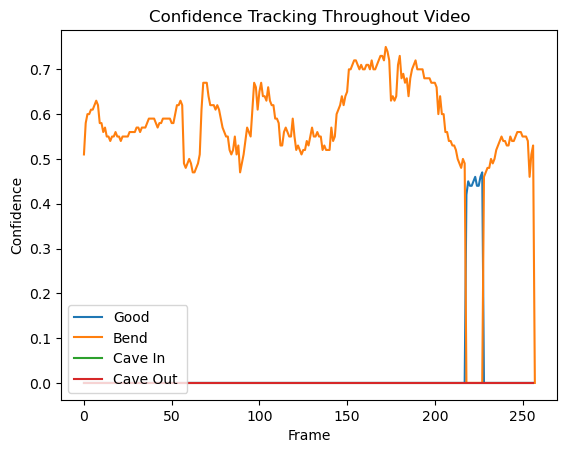

In [112]:
plt.plot(filtered_good_values, label='Good',fillstyle='none', linestyle='solid')
plt.plot(filtered_bend_values, label='Bend',fillstyle='none', linestyle='solid')
plt.plot(filtered_cavein_values, label='Cave In',fillstyle='none', linestyle='solid')
plt.plot(filtered_caveout_values, label='Cave Out ',fillstyle='none', linestyle='solid')

plt.xlabel('Frame')
plt.ylabel('Confidence')
plt.title('Confidence Tracking Throughout Video')
plt.legend(loc=('lower left'))
plt.show()

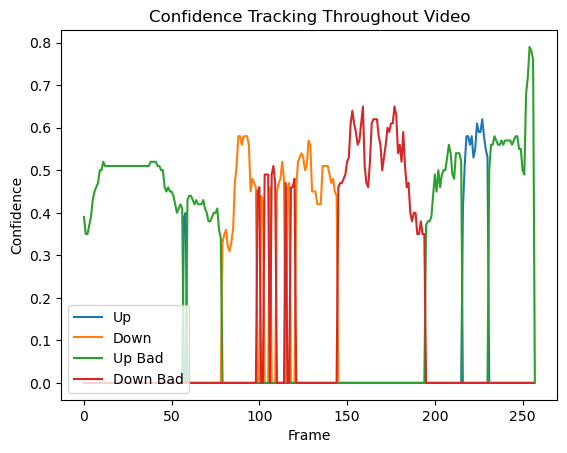

In [113]:
plt.plot(filtered_up_values, label='Up',fillstyle='none', linestyle='solid')
plt.plot(filtered_down_values, label='Down',fillstyle='none', linestyle='solid')
plt.plot(filtered_upbad_values, label='Up Bad',fillstyle='none', linestyle='solid')
plt.plot(filtered_downbad_values, label='Down Bad',fillstyle='none', linestyle='solid')


plt.xlabel('Frame')
plt.ylabel('Confidence')
plt.title('Confidence Tracking Throughout Video')
plt.legend(loc=('lower left'))
plt.show()